![](https://www.broadinstitute.org/files/images/GoogleGenomics.png)

## GenX secondary analysis on GCP - GATK with new config

#### Fist,  let's pull in some git repos 

In [ ]:
%%bash
git clone https://github.com/googlegenomics/pipelines-api-examples.git  #to run it on GCP
git clone https://github.com/broadinstitute/wdl.git                     #the actual wdl scripts running the algos  
git clone https://github.com/openwdl/wdl.git open_wdl                   # use a yaml from G (skip if you write your own)  

In [4]:
ls

GenX_demo.ipynb  open_wdl/  pipelines-api-examples/  wdl/


### Let's see what the input (reference and test genomes) looks like

In [4]:
%%bash
cat wdl/scripts/broad_pipelines/germline-short-variant-discovery/gvcf-generation-per-sample/1.0.0/GOTC_PairedEndSingleSampleWf.inputs.json

{
  "##_COMMENT1": "SAMPLE-SPECIFIC - MUST BE ADAPTED TO YOUR DATA !!! (fingerprint file is optional -- comment out if unavailable)",
  "PairedEndSingleSampleWorkflow.sample_name": "NA12878",
  "PairedEndSingleSampleWorkflow.base_file_name": "NA12878",
  "PairedEndSingleSampleWorkflow.flowcell_unmapped_bams": [
    "gs://genomics-public-data/test-data/dna/wgs/hiseq2500/NA12878/H06HDADXX130110.1.ATCACGAT.20k_reads.bam",
    "gs://genomics-public-data/test-data/dna/wgs/hiseq2500/NA12878/H06HDADXX130110.2.ATCACGAT.20k_reads.bam",
    "gs://genomics-public-data/test-data/dna/wgs/hiseq2500/NA12878/H06JUADXX130110.1.ATCACGAT.20k_reads.bam"
  ],
  "PairedEndSingleSampleWorkflow.final_gvcf_name": "NA12878.g.vcf.gz",
  "PairedEndSingleSampleWorkflow.fingerprint_genotypes_file": "gs://dsde-data-na12878-public/NA12878.hg38.reference.fingerprint.vcf",

  "##_COMMENT2": "INTERVALS", 
  "PairedEndSingleSampleWorkflow.wgs_calling_interval_list": "gs://broad-references/hg38/v0/wgs_calling_regions.hg38

#### Lets take a look at the  yaml config file

In [5]:
%%bash
cat open_wdl/runners/cromwell_on_google/wdl_runner/wdl_pipeline.yaml \

name: WDL Runner
description: Run a workflow defined by a WDL file

inputParameters:
- name: WDL
  description: Workflow definition
- name: WORKFLOW_INPUTS
  description: Workflow inputs
- name: WORKFLOW_OPTIONS
  description: Workflow options

- name: WORKSPACE
  description: Cloud Storage path for intermediate files
- name: OUTPUTS
  description: Cloud Storage path for output files

docker:
  imageName: gcr.io/broad-dsde-outreach/wdl_runner:2017_10_02

  cmd: >
    /wdl_runner/wdl_runner.sh

resources:
  minimumRamGb: 3.75


#### Create bucket for outputs/logs etc. (if you don't have it)

In [6]:
%%bash
gsutil ls

gs://sv-ml-sandbox/
gs://sv-tf-model-1/
gs://sv-vdv-output1/


In [8]:
pwd

u'/content/datalab/notebooks/SV_notebooks/GenX'

![](http://www.broadinstitute.org/gatk/img/GATK_BPP_white.gif)

#### configure the pipeline and kick it off

In [10]:
%%bash

gcloud alpha genomics pipelines run \
  --pipeline-file /content/datalab/notebooks/SV_notebooks/GenX/open_wdl/runners/cromwell_on_google/wdl_runner/wdl_pipeline.yaml \
  --zones us-central1-f \
  --memory 5 \
  --logging gs://sv-ml-sandbox/logging \
  --inputs-from-file WDL=/content/datalab/notebooks/SV_notebooks/GenX/wdl/scripts/broad_pipelines/germline-short-variant-discovery/gvcf-generation-per-sample/0.2.0/PublicPairedSingleSampleWf_170412.wdl \
  --inputs-from-file WORKFLOW_INPUTS=/content/datalab/notebooks/SV_notebooks/GenX/wdl/scripts/broad_pipelines/germline-short-variant-discovery/gvcf-generation-per-sample/0.2.0/PublicPairedSingleSampleWf_170412.inputs.json \
  --inputs-from-file WORKFLOW_OPTIONS=/content/datalab/notebooks/SV_notebooks/GenX/wdl/scripts/broad_pipelines/germline-short-variant-discovery/gvcf-generation-per-sample/0.2.0/PublicPairedSingleSampleWf_170412.options.json\
  --inputs WORKSPACE=gs://sv-ml-sandbox/workspace \
  --inputs OUTPUTS=gs://sv-ml-sandbox/outputs

Running [operations/EI7s8d2NLBjXj-attNPAowog4r3yw4IMKg9wcm9kdWN0aW9uUXVldWU].


![](http://www.imageno.com/image.php?id=4rmhohgrwxgm&kk=17753044)

#### verify status of pipeline

In [12]:
%%bash 
gcloud alpha genomics operations cancel EI7s8d2NLBjXj-attNPAowog4r3yw4IMKg9wcm9kdWN0aW9uUXVldWU --format='yaml(done, error, metadata.events)'

done: false
metadata:
  events:
  - description: start
    startTime: '2018-01-09T16:24:31.676287835Z'
  - description: pulling-image
    startTime: '2018-01-09T16:24:31.676350602Z'

This operation will be canceled

Do you want to continue (Y/n)?  
Canceled [operations/EI7s8d2NLBjXj-attNPAowog4r3yw4IMKg9wcm9kdWN0aW9uUXVldWU].


#### also verify pipeline stages in pantheon and in the bucket

In [13]:
%%bash 
gsutil ls gs://sv-ml-sandbox/

gs://sv-ml-sandbox/logging/
gs://sv-ml-sandbox/outputs/
gs://sv-ml-sandbox/workspace/


In [14]:
%%bash 
gsutil ls gs://sv-ml-sandbox/outputs

gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.base_distribution_by_cycle.pdf
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.base_distribution_by_cycle_metrics
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.insert_size_histogram.pdf
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.insert_size_metrics
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.quality_by_cycle.pdf
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.quality_by_cycle_metrics
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.quality_distribution.pdf
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.readgroup.quality_distribution_metrics
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.unmapped.quality_yield_metrics
gs://sv-ml-sandbox/outputs/H06HDADXX130110.1.ATCACGAT.20k_reads.validation_report
gs://sv-ml-sandbox/

![](

# GWAS

## Genomics Tertiary analysis on GCP

### Design

We'll be replicating a clinical study: Control Group and Test Group. 
One will be the reference and the other will the phenotype carrier (plug in here any pathology worth investigating at the Genetic level)

Our goal is to filter through BILLIONS of variants and pnpoint only the variant calls (for the sake of time  we'll do this within one chromosome, let's say the #12) that differs significantly between the case and control groups. If we can identify and isolate that we'll have a good chance of identifying a 'genenotype phenotype causality' (in other words identify what a the genetic level creates the pathology - in real life/research is not that easy but this is just a demo)

The case group for the purposes of this notebook will be individuals from the "EAS" (East Asian) super population. Variant data from the 1000 genomes dataset is publicly accessible within BigQuery.

We'll make the EAS group our test group and use the rest of the 1000 genomes as the control group.

We'll compare them and isolate the most meaningful differences

In [5]:
import datalab.bigquery as bq
variants_table = bq.Table('genomics-public-data:1000_genomes.variants')
variants_table.schema

[{ 'name': 'reference_name', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'An identifier from the reference genome or an angle-bracketed ID String pointing to a contig in the assembly file.' },
 { 'name': 'start', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'The reference position, with the first base having position 0.' },
 { 'name': 'end', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'INFO=<ID=END,Number=1,Type=Integer,Description="End position of the variant described in this record">' },
 { 'name': 'reference_bases', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'Each base must be one of A,C,G,T,N (case insensitive). Multiple bases are permitted. The value in the POS field refers to the position of the first base in the String.' },
 { 'name': 'alternate_bases', 'type': 'STRING', 'mode':'REPEATED', 'description': 'List of alternate non-reference alleles called on at least one of the samples. ("at least one" not true for this dataset)' },
 { 'name': 'quality', 'type': 'FLOAT', 'mode':'NULLABLE', 'description': 'phred-scaled quality score for the assertion made in ALT.' },
 { 'name': 'filter', 'type': 'STRING', 'mode':'REPEATED', 'description': 'PASS if this position has passed all filters, i.e. a call is made at this position. Otherwise, if the site has not passed all filters, a list of codes for filters that fail.' },
 { 'name': 'names', 'type': 'STRING', 'mode':'REPEATED', 'description': 'List of unique identifiers for the variant where available.' },
 { 'name': 'call', 'type': 'RECORD', 'mode':'REPEATED', 'description': 'Per-sample measurements.' },
 { 'name': 'call.call_set_id', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'The id of the callset from which this data was exported from the Google Genomics Variants API.' },
 { 'name': 'call.call_set_name', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'Sample identifier.' },
 { 'name': 'call.genotype', 'type': 'INTEGER', 'mode':'REPEATED', 'description': 'List of genotypes.' },
 { 'name': 'call.phaseset', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'If this value is null, the data is unphased.  Otherwise it is phased.' },
 { 'name': 'call.genotype_likelihood', 'type': 'FLOAT', 'mode':'REPEATED', 'description': 'List of genotype likelihoods.' },
 { 'name': 'call.DP', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=DP,Number=1,Type=Integer,Description="# high-quality bases">' },
 { 'name': 'call.DS', 'type': 'FLOAT', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=DS,Number=1,Type=Float,Description="Genotype dosage from MaCH/Thunder">' },
 { 'name': 'call.FT', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'None' },
 { 'name': 'call.GQ', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=GQ,Number=1,Type=Float,Description="Genotype quality">' },
 { 'name': 'call.PL', 'type': 'INTEGER', 'mode':'REPEATED', 'description': 'FORMAT=<ID=PL,Number=.,Type=Integer,Description="List of Phred-scaled genotype likelihoods, number of values is (#ALT+1)*(#ALT+2)/2">' },
 { 'name': 'call.SP', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'FORMAT=<ID=SP,Number=1,Type=Integer,Description="Phred-scaled strand bias P-value">' },
 { 'name': 'AA', 'type': 'STRING', 'mode':'NULLABLE', 'description': 'INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele, ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/technical/reference/ancestral_alignments/README">' },
 { 'name': 'AC', 'type': 'INTEGER', 'mode':'REPEATED', 'description': 'INFO=<ID=AC,Number=.,Type=Integer,Description="Alternate Allele Count">' },
 { 'name': 'AC1', 'type': 'INTEGER', 'mode':'NULLABLE', 'description': 'INFO=<ID=AC1,Number=1,Type=Float,Description="Max-likelihood estimate of the first ALT allele count (no HWE assumption)">' },
 { 'name': 'AF', 'type': 'FLOAT', 'mode':'NULLABLE', 'description': 'INFO=<ID=AF,Number=1,Type=Float,Description="Global Allele Frequency based on AC/AN">' },
 { 'name': 'AF1', 'type': 'FLOAT', 'mode':'NULLA

In [8]:
%%sql --module allele_counts

SELECT 
    reference_name,
    start,
    reference_bases,
    alternate_bases,
    end,
    vt,    
    call.call_set_name AS call_set_name,
    # 1000 genomes phase 1 data is bi-allelic so there is only ever a single alt
    SUM(0 = call.genotype) WITHIN RECORD AS ref_count,
    SUM(1 = call.genotype) WITHIN RECORD AS alt_count,
FROM
  FLATTEN((
    SELECT
      reference_name,
      start,
      reference_bases,
      alternate_bases,
      end,
      vt,
      call.call_set_name,
      call.genotype,
    FROM
      $variants_table
    WHERE
      reference_name = '12' -- i.e., chromosome 12
    ),
    call)

In [9]:
bq.Query(allele_counts, variants_table=variants_table).sample().to_dataframe()

,reference_name,start,reference_bases,alternate_bases,end,vt,call_set_name,ref_count,alt_count
0,12,54319726,A,G,54319727,SNP,HG00261,0,2
1,12,54319726,A,G,54319727,SNP,HG00593,0,2
2,12,54319726,A,G,54319727,SNP,NA12749,1,1
3,12,54319726,A,G,54319727,SNP,HG00150,0,2
4,12,54319726,A,G,54319727,SNP,NA19675,0,2


### Classifying per-call variant positions into variant/non-variant groups

We can SUM the reference/alternate allele accounts for individual variant positions within chromosome 12.

The field call.genotype is an integer ranging from [-1, num_alternate_bases].

A value of negative one indicates that the genotype for the call is ambiguous (i.e., a no-call). A value of zero indicates that the genotype for the call is the same as the reference (i.e., non-variant). A value of one would indicate that the genotype for the call is the 1st value in the list of alternate bases (likewise for values >1).

In [10]:
sample_info_table = bq.Table('genomics-public-data:1000_genomes.sample_info')

In [11]:
bq.Query(allele_counts, variants_table=variants_table).sample().to_dataframe()

,reference_name,start,reference_bases,alternate_bases,end,vt,call_set_name,ref_count,alt_count
0,12,54319726,A,G,54319727,SNP,HG00261,0,2
1,12,54319726,A,G,54319727,SNP,HG00593,0,2
2,12,54319726,A,G,54319727,SNP,NA12749,1,1
3,12,54319726,A,G,54319727,SNP,HG00150,0,2
4,12,54319726,A,G,54319727,SNP,NA19675,0,2


### Assigning case and control groups

We can join our allele counts with metadata available in the sample info table.

Use this sample metadata to split the set of genomes into case and control groups based upon the super population group.

In [12]:
%%sql --module exp_groups

SELECT
  super_population,
  ('EAS' = super_population) AS is_case,
  call_set_name,
  reference_name,
  start,
  reference_bases,
  alternate_bases,
  end,
  vt,
  ref_count,
  alt_count,
FROM $allele_counts AS allele_counts
JOIN $sample_info_table AS samples
  ON allele_counts.call_set_name = samples.sample

In [13]:
bq.Query(exp_groups, allele_counts=allele_counts,
                     sample_info_table=sample_info_table,
                     variants_table=variants_table).sample().to_dataframe()

,super_population,is_case,call_set_name,reference_name,start,reference_bases,alternate_bases,end,vt,ref_count,alt_count
0,EUR,False,HG00261,12,96851333,CT,C,96851335,INDEL,2,0
1,EAS,True,HG00593,12,96851333,CT,C,96851335,INDEL,2,0
2,EUR,False,NA12749,12,96851333,CT,C,96851335,INDEL,2,0
3,EUR,False,HG00150,12,96851333,CT,C,96851335,INDEL,2,0
4,AMR,False,NA19675,12,96851333,CT,C,96851335,INDEL,2,0


In [14]:
%%sql
SELECT 
  vt,
  COUNT(*)
FROM $exp_groups
GROUP BY vt

vt,f0_
SNP,1921583664
SV,745836
INDEL,73853052


### close to TWO BILLIONS SNPs. For the purposes of this DEMO we'll  limit the variants to only SNPs.

In [15]:
%%sql --module snps
SELECT * 
FROM $exp_groups
WHERE vt='SNP'

In [16]:
bq.Query(snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).sample().to_dataframe()

,super_population,is_case,call_set_name,reference_name,start,reference_bases,alternate_bases,end,vt,ref_count,alt_count
0,EUR,False,HG00261,12,42065938,G,T,42065939,SNP,2,0
1,EAS,True,HG00593,12,42065938,G,T,42065939,SNP,2,0
2,EUR,False,NA12749,12,42065938,G,T,42065939,SNP,2,0
3,EUR,False,HG00150,12,42065938,G,T,42065939,SNP,2,0
4,AMR,False,NA19675,12,42065938,G,T,42065939,SNP,2,0


### SUMMING reference/alternate allele counts for case/control groups 

### Now that we've assigned each call set to either the case or the control group, we can tally up the counts of reference and alternate alleles within each of our assigned case/control groups, for each variant position, like so: 

In [17]:
%%sql --module grouped_counts

SELECT
    reference_name,
    start,
    end,
    reference_bases,
    alternate_bases,
    vt,
    SUM(ref_count + alt_count) AS allele_count,
    SUM(ref_count) AS ref_count,
    SUM(alt_count) AS alt_count,
    SUM(IF(TRUE = is_case, INTEGER(ref_count + alt_count), 0)) AS case_count,
    SUM(IF(FALSE = is_case, INTEGER(ref_count + alt_count), 0)) AS control_count,
    SUM(IF(TRUE = is_case, ref_count, 0)) AS case_ref_count,
    SUM(IF(TRUE = is_case, alt_count, 0)) AS case_alt_count,
    SUM(IF(FALSE = is_case, ref_count, 0)) AS control_ref_count,
    SUM(IF(FALSE = is_case, alt_count, 0)) AS control_alt_count,
FROM $snps
GROUP BY
    reference_name,
    start,
    end,
    reference_bases,
    alternate_bases,
    vt

In [18]:
bq.Query(grouped_counts,
         snps=snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).sample().to_dataframe()

,reference_name,start,end,reference_bases,alternate_bases,vt,allele_count,ref_count,alt_count,case_count,control_count,case_ref_count,case_alt_count,control_ref_count,control_alt_count
0,12,128192925,128192926,C,T,SNP,2184,2175,9,572,1612,572,0,1603,9
1,12,12239049,12239050,A,C,SNP,2184,1739,445,572,1612,503,69,1236,376
2,12,30035672,30035673,G,A,SNP,2184,2182,2,572,1612,572,0,1610,2
3,12,7397689,7397690,C,G,SNP,2184,151,2033,572,1612,0,572,151,1461
4,12,68320384,68320385,C,G,SNP,2184,2152,32,572,1612,572,0,1580,32


### Quantify the statistical significance at each variant positions

### We can quantify the statistical significance of each variant position using the Chi-squared test. Furthermore, we can restrict our result set to only statistically significant variant positions for this experiment by ranking each position by its statistical signficance (decreasing) and thresholding the results for significance at p <= 5e-8 (chi-squared score >= 29.7).

In [19]:
%%sql --module results

SELECT
  reference_name,
  start,
  end,
  reference_bases,
  alternate_bases,
  vt,
  case_count,
  control_count,
  allele_count,
  ref_count,
  alt_count,
  case_ref_count,
  case_alt_count,
  control_ref_count,
  control_alt_count,


  ROUND(
    POW(ABS(case_ref_count - (ref_count/allele_count)*case_count) - 0.5,
      2)/((ref_count/allele_count)*case_count) +
    POW(ABS(control_ref_count - (ref_count/allele_count)*control_count) - 0.5,
      2)/((ref_count/allele_count)*control_count) +
    POW(ABS(case_alt_count - (alt_count/allele_count)*case_count) - 0.5,
      2)/((alt_count/allele_count)*case_count) +
    POW(ABS(control_alt_count - (alt_count/allele_count)*control_count) - 0.5,
      2)/((alt_count/allele_count)*control_count),
    3) AS chi_squared_score
FROM $grouped_counts
WHERE
  # For chi-squared, expected counts must be at least 5 for each group
  (ref_count/allele_count)*case_count >= 5.0
  AND (ref_count/allele_count)*control_count >= 5.0
  AND (alt_count/allele_count)*case_count >= 5.0
  AND (alt_count/allele_count)*control_count >= 5.0
HAVING
  # Chi-squared critical value for df=1, p-value=5*10^-8 is 29.71679
  chi_squared_score >= 29.71679
ORDER BY
  chi_squared_score DESC,
  allele_count DESC

In [20]:
bq.Query(results,
         grouped_counts=grouped_counts,
         snps=snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).sample().to_dataframe()

,reference_name,start,end,reference_bases,alternate_bases,vt,case_count,control_count,allele_count,ref_count,alt_count,case_ref_count,case_alt_count,control_ref_count,control_alt_count,chi_squared_score
0,12,110571373,110571374,A,G,SNP,572,1612,2184,1813,371,220,352,1593,19,1086.505
1,12,22509094,22509095,T,C,SNP,572,1612,2184,1589,595,116,456,1473,139,1073.082
2,12,22525352,22525353,A,C,SNP,572,1612,2184,1585,599,115,457,1470,142,1068.266
3,12,22524240,22524241,T,C,SNP,572,1612,2184,1584,600,115,457,1469,143,1065.294
4,12,33240567,33240568,C,G,SNP,572,1612,2184,1678,506,159,413,1519,93,1043.029


### the positions deemed significant do in fact have significantly different case/control counts for the alternate/reference bases.

### Computing Chi-squared statistics in BigQuery vs Python

### Let's compare these BigQuery-computed Chi-squared scores to ones calculated via Python's statistical packages

In [21]:
import numpy as np
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(np.array([ 
    [220, 352], # case 
    [1593, 19]  # control
]))

print 'Python Chi-sq score = %.3f' % chi2

Python Chi-sq score = 1086.505


### We can see that for the computation in Python the value matches 1086.505 from BigQuery. ( repeat this in R and see that result values match)

### Analyzing the GWAS results

### First, how many statistically significant variant positions did we find?

In [22]:
%%sql 
SELECT COUNT(*) AS num_significant_snps
FROM $results

num_significant_snps
224332


In [23]:
%%sql --module sig_snps_dataset
SELECT * FROM (
  SELECT
    reference_name,
    start,
    reference_bases,
    alternate_bases,
    chi_squared_score
  FROM $results
  LIMIT 1000
)
ORDER BY start asc

In [24]:
sig_snps = bq.Query(sig_snps_dataset, 
                    results=results,
                    grouped_counts=grouped_counts,
                    snps=snps,
                    exp_groups=exp_groups,
                    allele_counts=allele_counts,
                    sample_info_table=sample_info_table,
                    variants_table=variants_table).to_dataframe()

sig_snps[:10]

,reference_name,start,reference_bases,alternate_bases,chi_squared_score
0,12,1595431,A,G,744.125
1,12,1600977,A,T,828.910
2,12,2129565,C,T,711.515
3,12,2132494,T,C,753.874
4,12,2134197,A,G,822.961
5,12,2138687,C,A,706.309
6,12,2139264,A,C,769.534
7,12,2140624,T,C,704.880
8,12,2141908,C,T,790.150
9,12,6505528,T,G,768.788


### Let's visualize the distribution of significant SNPs along the length of the chromosome.

### The y-value of the charts indicates the Chi-squared score: larger values are more significant.

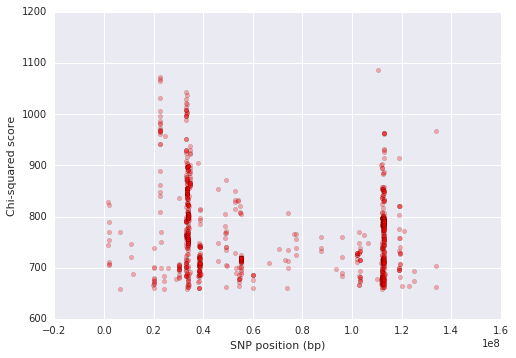

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

#g = sns.distplot(sig_snps['start'], rug=False, hist=False, kde_kws=dict(bw=0.1))
fig, ax = plt.subplots()
ax.scatter(sig_snps['start'], sig_snps['chi_squared_score'], alpha=0.3, c='red')
ax.set_ylabel('Chi-squared score')
ax.set_xlabel('SNP position (bp)')

### ok, now Let's zoom in on one region that contains a large number of very significant SNPs:

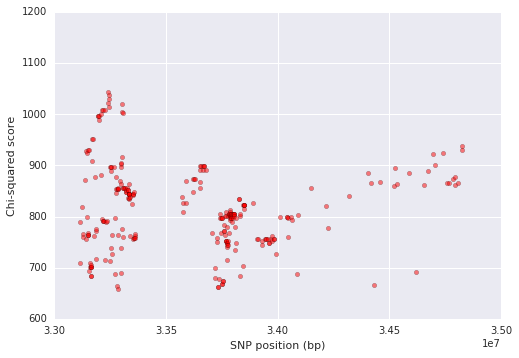

In [26]:
fig, ax = plt.subplots()
ax.scatter(sig_snps['start'], sig_snps['chi_squared_score'], alpha=0.5, c='red')
ax.set_xlim([3.3e7, 3.5e7])
ax.set_ylabel('Chi-squared score')
ax.set_xlabel('SNP position (bp)')

### Further exploration of statistically significant variant positions:

### We can take our analysis further by mapping selected variant positions back to the chromosome and visualizing call sets and reads. Let's retrieve 'The TOP ONE' SNP identified when ranked by the Chi-squared score:

In [27]:
%%sql --module top_snp
SELECT start
FROM $sig_snps_dataset
ORDER BY chi_squared_score desc
LIMIT 1

In [28]:
bq.Query(top_snp,
         sig_snps_dataset=sig_snps_dataset,
         results=results,
         grouped_counts=grouped_counts,
         snps=snps,
         exp_groups=exp_groups,
         allele_counts=allele_counts,
         sample_info_table=sample_info_table,
         variants_table=variants_table).results()

start
110571373


### That is IT. The most meaninful SNP variant beteween my control (read HEALTHY) group and my test (read SICK) group and this is 'the most likely culprit' (again, in reality is more complex but for the sake of the demo let's say this is our Agatha Christie moment    

### Now just to show  how the genome Browser looks let's the grab an arbitrary set of 10 callset IDs for rendering in the genome browser.

In [29]:
%%sql --module callset_ids
SELECT * FROM (
  SELECT call.call_set_id AS callset_id
  FROM $variants_table
  GROUP BY callset_id)
LIMIT 10

In [30]:
callsets_df = bq.Query(callset_ids, variants_table=variants_table).to_dataframe()
callsets = list(callsets_df['callset_id'])

In [31]:

from IPython.display import HTML
def gabrowse(dataset, reference_name, start_position, callset_ids):
    callsets_query_params = ''.join('&callsetId=%s&cBackend=GOOGLE' % callset_id for callset_id in callset_ids)
    url = ('https://gabrowse.appspot.com/#=&backend=GOOGLE&location=12%3A'
         + str(start_position)
         + callsets_query_params)
    return HTML('<iframe src="%s" width=1024 height=800></iframe>' % url)

### Now we can render the call sets and reads for the selected SNP position by embedding the GABrowse application directly in our notebook.

In [33]:
gabrowse('1000genomes', '12', 110571373, callsets)

### TO SUMMARIZE IT ALL: 
### FIRST: this notebook illustrated how to run a genomic analysis pipeline on GCP 
### SECOND: how to conduct an entire GWAS experiment (which, for non-GCP users,  requires piping together 4 to 5 different tools and scripting the conections between the tools and the various languages et.c). 
### We accomplished both tasks from the same place (DATALAB) leaveraging many resources in the GCP Echosystem (GCS, GCE, GKE, BQ etc.) using publicly available VERY ALRGE variant data stored in BQ tables, and query it a AMAZING speed. Lastly after the filtering was done we imported a local copy of the most "clinically meaningful results" and visualized them with Python libraries. All from within one tool.
